In [1]:
import scipy.io
import numpy as np

from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt

# Loading & Formatting the data

In [2]:
time = 1381528818
train_data = np.load('data/train_{}.npy'.format(time))
val_data = np.load('data/val_{}.npy'.format(time))
test_data = np.load('data/test_{}.npy'.format(time))

In [3]:
train_data.shape

(10, 7200)

# Training

Everything here is strongly influenced/ copied from the DeepClean setup as documented [here](https://git.ligo.org/tri.nguyen/deepclean-prod/-/tree/master?ref_type=heads)

In [4]:
class TimeSeriesSegmentDataset(Dataset):

    def __init__(self, data, kernel, stride, fs, pad_mode='median', target_idx=0):

        super().__init__()

        self.kernel = kernel
        self.stride = stride
        self.fs = fs
        self.pad_mode = pad_mode
        self.data = data
        self.target_idx = target_idx

    def __len__(self):
        """ Return the number of stride """
        nsamp = self.data.shape[-1]
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        n_stride = int(np.ceil((nsamp - kernel) / stride) + 1)
        return max(0, n_stride)

    def __getitem__(self, idx):
        """ Get sample Tensor for a given index """
        # check if idx is valid:
        if idx < 0:
            idx +=  self.__len__()
        if idx >= self.__len__():
            raise IndexError(
                f'index {idx} is out of bound with size {self.__len__()}.')

        # get sample
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        idx_start = idx * stride
        idx_stop = idx_start + kernel
        data = self.data[:, idx_start: idx_stop].copy()

        # apply padding if needed
        nsamp = data.shape[-1]
        if nsamp < kernel:
            pad = kernel - nsamp
            data = np.pad(data, ((0, 0), (0, pad)), mode=self.pad_mode)

        # separate into target strain and witnesses
        target = data[self.target_idx]
        target = target[:, np.newaxis]
        aux = np.delete(data, self.target_idx, axis=0)

        # convert into Tensor
        target = torch.Tensor(target)
        aux = torch.Tensor(aux)
        aux = aux.transpose(-1, -2)

        return aux, target

In [5]:
train = TimeSeriesSegmentDataset(train_data, 60.0, 1.0, 4, target_idx=9)
train_loader = DataLoader(train, 32, num_workers=1)
valid = TimeSeriesSegmentDataset(val_data, 60.0, 1.0, 4, target_idx=9)
val_loader = DataLoader(valid, 32, num_workers=1)
test = TimeSeriesSegmentDataset(test_data, 60.0, 1.0, 4, target_idx=9)
test_loader = DataLoader(test, 32, num_workers=1)

# Setting-up S4D model

In [6]:
from models.s4d import S4D
import torch.nn as nn
dropout_fn = nn.Dropout2d

d_input = 9 # number of channels (here all witness channels -> 9)
d_output = 1 # number of outputs (here regression of residual motion -> 1)

In [7]:
# definition of SSM here
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input, d_model)
        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))
        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)
        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)
        
        return x

In [8]:
# Model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print('==> Building model..')
model = S4Model(d_input=d_input, d_output=d_output, d_model=4, n_layers=2, dropout=0.0, prenorm=False)
model = model.to(device)
print('...done!')

cuda
==> Building model..
...done!


In [9]:
import torch.optim as optim
def setup_optimizer(model, lr, weight_decay, epochs):
    all_parameters = list(model.parameters())
    params = [p for p in all_parameters if not hasattr(p, "_optim")]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

criterion = torch.nn.MSELoss(reduction='mean')
optimizer, scheduler = setup_optimizer(model, lr=0.01, weight_decay=0.01, epochs=10)

Optimizer group 0 | 16 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 6 tensors | lr 0.001 | weight_decay 0.0


## Actual training

In [10]:
best_loss = np.inf  # best test loss
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
doc_loss = []
doc_val = []

In [11]:
import os

# Training
from tqdm.auto import tqdm
def train():
    model.train()
    train_loss = 0
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f ' %
            (batch_idx, len(train_loader), train_loss/(batch_idx+1))
        )
        doc_loss.append(train_loss/(batch_idx+1))

def eval(epoch, dataloader, checkpoint=False):
    global best_loss
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1))
            )
            doc_val.append(eval_loss/(batch_idx+1))

    # Save checkpoint.
    if checkpoint:
        if loss < best_loss:
            state = {
                'model': model.state_dict(),
                'loss': loss,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_loss = loss
        

        return loss

pbar = tqdm(range(start_epoch, 75))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val loss: %1.3f' % (epoch, val_loss))
    train()
    val_loss = eval(epoch, val_loader, checkpoint=True)
    #eval(epoch, test_loader)
    scheduler.step()

/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch: 0:   0%|          | 0/75 [00:00<?, ?it/s]
0it [00:00, ?it/s]/n/holylabs/LABS/iaifi_lab/Users/creissel/miniforge3/envs/ssm/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "

Batch Idx: (0/5

### Plotting and diagnostics of training

In [12]:
loss = []
x = len(train_loader)
for i in range(0, len(doc_loss), x): loss.append(sum(doc_loss[i:i + x])/len(train_loader))

val = []
x = len(val_loader)
for i in range(0, len(doc_val), x): val.append(sum(doc_val[i:i + x])/len(val_loader))

epochs = np.arange(0,len(loss),1)

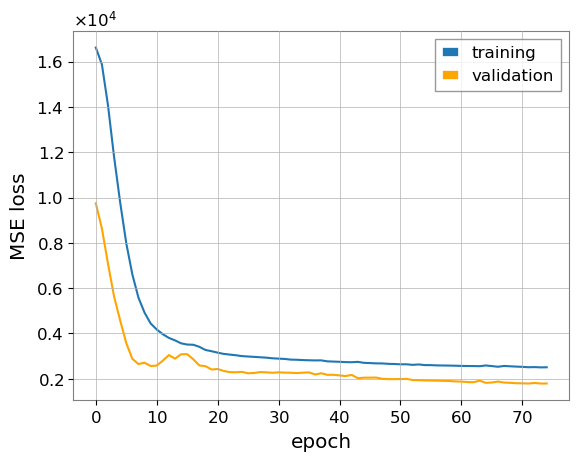

In [14]:
plt.plot(epochs, loss, label='training')
plt.plot(epochs, val, c='orange', label='validation')
plt.ylabel('MSE loss')
plt.xlabel('epoch')
#plt.ylim([0.0,0.45])
plt.legend()
plt.show()

# Inference

In [15]:
# run inference
pred = []
model.eval()
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        pred.append(model(inputs).detach().cpu().numpy())

In [16]:
pred = np.concatenate(pred, axis=0)
pred = pred[:,:,0]

In [17]:
noverlap = int((60.0 - 1.0) * 4)

def overlap_add(data, noverlap, window, verbose=True):
    # Get dimension
    N, nperseg = data.shape
    stride = nperseg - noverlap

    # Get window function
    if isinstance(window, str):
        window = _parse_window(nperseg, noverlap, window)

    # Concatenate timeseries
    nsamp = int((N - 1) * stride + nperseg)
    new = np.zeros(nsamp)
    for i in range(N):
        new[i * stride: i * stride + nperseg] += data[i] * window
    return new

import scipy.signal as sig
def _parse_window(nperseg, noverlap, window='boxcar'):
    """ Get window function """
    if window == 'rect' or window =='rectangular':
        window = 'boxcar'
    if window == 'hanning':
        window = 'hann'
    window_fn = sig.get_window(window, nperseg)
    if window != 'boxcar':
        return window_fn * (nperseg - noverlap) / nperseg * 2
    else:
        return window_fn * (nperseg - noverlap) / nperseg

In [18]:
pred = overlap_add(pred, noverlap, 'hanning')


In [19]:
true = test_data[9,:]

# remove first and last kernel
true = true[60*4:-60*4]
pred = pred[60*4:-60*4]


### Plot: results (not postprocessed)

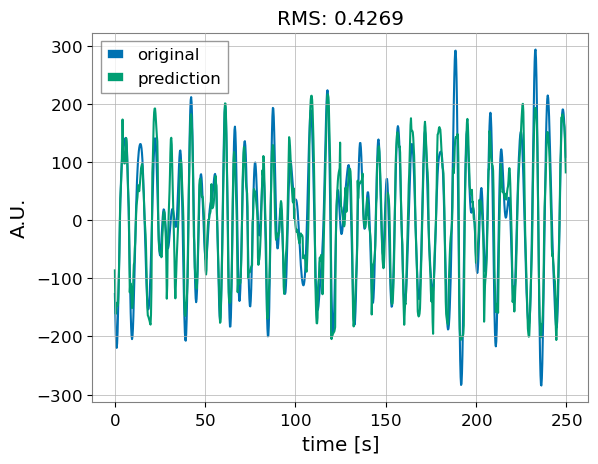

In [20]:
plt.plot(np.arange(0,1000/4.,1/4.), true[:1000], label='original', color='#0072B2')
plt.plot(np.arange(0,1000/4.,1/4.), pred[:1000], label='prediction', color='#009E73')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((pred-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('A.U.')
plt.legend()

### Plot: results (reverse the normalization)

In [ ]:
utils = np.load('data/norm/utils_{}.npz'.format(time))
mean = utils['mean']
std = utils['std']

# convert back to unit of target
pred *= std[9].ravel()
pred += mean[9].ravel()

true = true*std[9].ravel() 
true += mean[9].ravel()

In [ ]:
plt.plot(np.arange(0,(1000.)/4.,1/4.), true[:1000], label='original', color='#0072B2')
plt.plot(np.arange(0,(1000.)/4.,1/4.), pred[:1000], label='prediction', color='#009E73')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((pred-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('elongation')
plt.legend()

### Plot: results (reverse the normalization, with bandpass to 0.1-0.3 Hz)

In [21]:
strain_pred = TimeSeries(pred, dt=1/4.)
#strain_pred_bp = strain_pred.bandpass(0.1, 0.3)
strain_pred_bp = strain_pred

In [22]:
strain_org = TimeSeries(true, dt=1/4.)

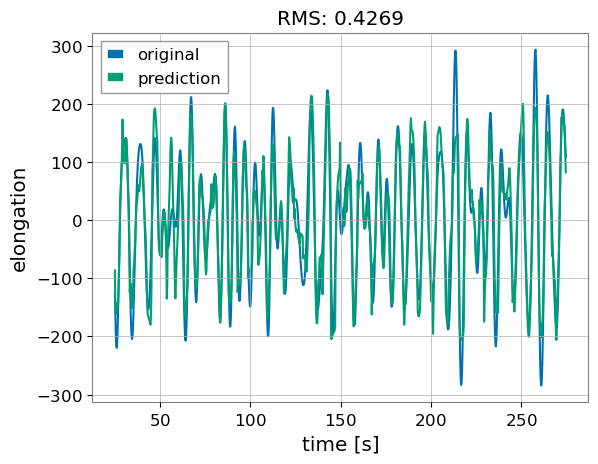

In [23]:
plt.plot(np.arange(100/4.,1100/4.,1/4.), true[:1000], label='original', color='#0072B2')
plt.plot(np.arange(100/4.,1100/4.,1/4.), strain_pred_bp.value[:1000], label='prediction', color='#009E73')
plt.title('RMS: %.4f' %(np.sqrt(np.mean((strain_pred_bp.value-true))**2)))
plt.xlabel('time [s]')
plt.ylabel('elongation')
plt.legend()

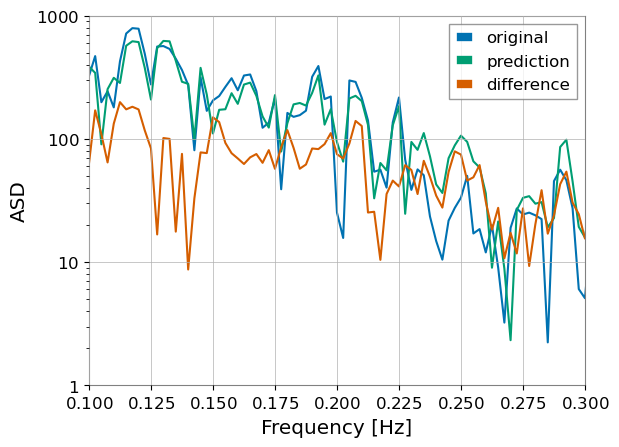

In [24]:
ASD_org = strain_org.asd(fftlength=400,overlap=0.1,method='median')
ASD_pred_bp = strain_pred_bp.asd(fftlength=400,overlap=0.1,method='median')
ASD_diff_bp = (strain_pred_bp-strain_org).asd(fftlength=400,overlap=0.1,method='median')

#plt.loglog(ASD_org, label='original')
#plt.loglog(ASD_pred_bp, label='prediction')
#plt.loglog(ASD_diff_bp, label='difference')
plt.plot(ASD_org, label='original', color='#0072B2')
plt.plot(ASD_pred_bp, label='prediction', color='#009E73')
plt.plot(ASD_diff_bp, label='difference', color='#D55E00')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.xlim([0.1,0.3])
plt.ylim([1, 10**3])
plt.yscale('log')
plt.legend()